Timeseries Classification: KNN & DTW
===
Mark Regan

---
When it comes to building a classification algorithm, analysts have a broad range of open source options to choose from. However, for time series classification, there are less out-of-the box solutions. Many of the typical classification algorithms (Logistic Regression, Random Forests, SVM etc) are applicable to time-series data when the temporal data structure is abstracted away through feature engineering.

My experience with this approach has been poor. The full timeseries feature vector contains a large amount of valuable information that can be lost through the process of flattening the datastructure.

I began researching the domain of time series classification and was intrigued by a recommended technique called K Nearest Neighbors and Dynamic Time Warping. A meta analysis completed by Mitsa (2010) suggests that when it comes to timeseries classification, 1 Nearest Neighbor (K=1) and Dynamic Timewarping is very difficult to beat [1].

##K Nearest Neighbors & Dynamic Time Warping

In [1]:
!pwd

/Users/mszekhov/Desktop/current_projects/hse_ts_course/2025-spring/seminars


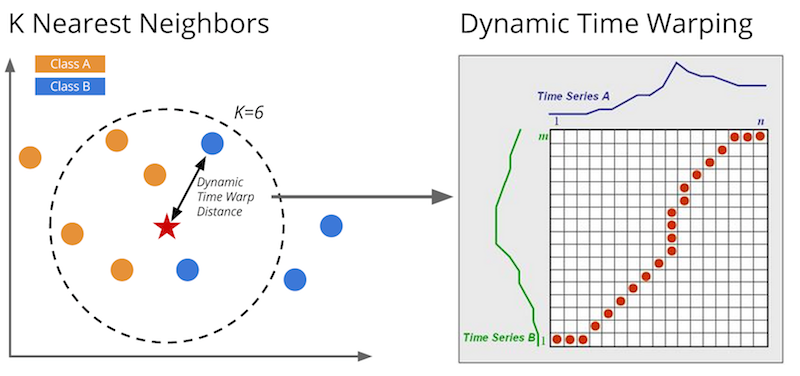

In [2]:
from IPython.display import Image
Image('./images/sem_15_dtw_knn_schematic.png', width=780)

K Nearest Neighbors is a classification algorithm familiar to many. It takes a unlabled observation (the star above) and compares it to a population of labled observations (blue and orange circles). By finding the K nearest circles to the star, we can infer the class label for the star through majority voting.

We can also use KNN in the context of time series data. The question becomes, "how do we compute the distance between two timeseries sequences"? "Dynamic Time Warping" is a technique that was heavily used for speech recognition in the 80s. The DTW algorithm finds the optimum alignment between two sequences of observations by warping the time dimension with certain constraints.

Because of this temporal dimension warping, DTW is good for classifying sequences that have different frequences or that are out of phase. Later we'll see how we can use DTW to classify whether a person is walking, lying down, sitting etc.

The above right diagram shows how a DTW distance matrix representation. Each cell is computed by measuring the distance between $A_i$ and $B_j$. The red path represents the shortest path and hence optimum alignment of the two sequences. 

$$DTW_{AB} = SUM(shortest\ paths_{AB})$$

####Max Warping Window Allowed
Computing the full distance matrix between A and B scales with $O(n^2)$, where n is the number of sequences in A and B. This performance can be improved by constraining the amount of warping allowed. This limits the number of cells that need to be computed in the DTW distance matrix. Research by Keogh et al has shown that a warping window not only improves performance but also improves classification accuracy [2].

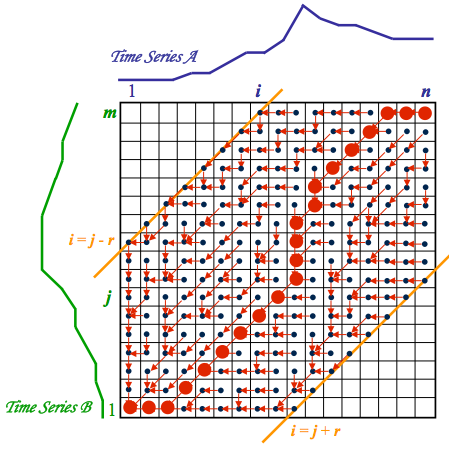

In [3]:
Image('images/sem_15_max_window_warping.png')

####Coded in Python
The below python code represents the KNN & DTW classification algorithm. The following key methods are described:

| Method        | Description                                                                                                           |
|---------------|-----------------------------------------------------------------------------------------------------------------------|
| `_dtw_distance` | computes the Dynamic Time Warping distance between two sequences                                                      |
| `_dist_matrix`  | computes the distance matrix between $A$ and $B$                  |
| `predict`       | uses both of the above methods to compute the class labels and probability of dataset $B$ through K Nearest Neighbors |

In [4]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = np.inf * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(np.shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        
        self.animate = self.animate_ipython
        

    def animate_ipython(self, iter):
        print(self, end='\r')
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

#### Measuring the DTW distance
The DTW distance between two sequences can be calculated using the `_dtw_distance()` method

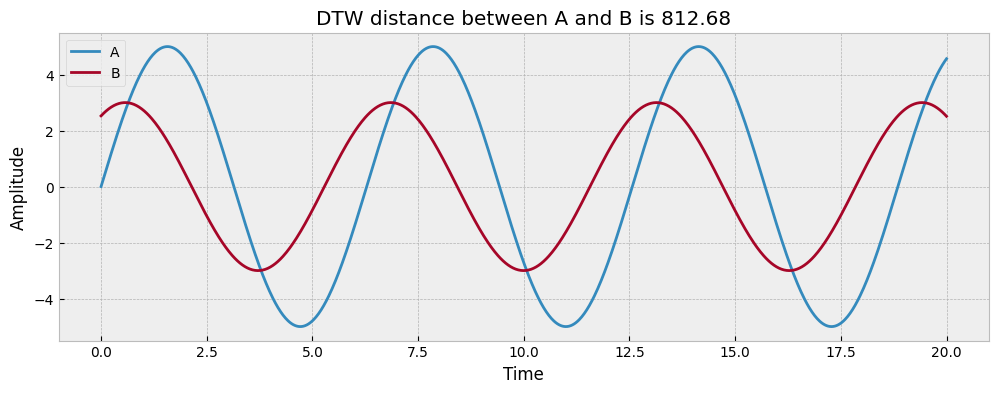

In [5]:
time = np.linspace(0,20,1000)
amplitude_a = 5*np.sin(time)
amplitude_b = 3*np.sin(time + 1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
_ = plt.plot(time, amplitude_a, label='A')
_ = plt.plot(time, amplitude_b, label='B')
_ = plt.title('DTW distance between A and B is %.2f' % distance)
_ = plt.ylabel('Amplitude')
_ = plt.xlabel('Time')
_ = plt.legend()

It is also possible to compute the distance between each pair of two collections of inputs by using the `_dist_matrix()` method. These are the two methods which underpin the KnnDtw() classification algorithm. In the next section we will use the `fit()` and `predict()` method to train our classifier and predict class labels forunseen data.

In [6]:
m._dist_matrix(np.random.random((4,50)), np.random.random((4,50)))

array([[ 9.91895282,  9.33800882,  8.31347461,  7.9756189 ],
       [ 8.76774877, 10.83035295,  8.75717219, 10.022824  ],
       [ 7.80169982,  8.74411981,  9.71984096,  8.63514011],
       [ 8.38278512,  8.43713495,  9.38346434,  9.05131258]])

## Human Activity Recognition Dataset
The Human Activity Recognition Dataset (HAR) dataset is chosen to test the classification performance of DTW & KNN [3].

> The experiments were carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually.

The remainder of this analysis uses a training and test dataset provided by the authors. They have combined the above timeseries signals and created a single timeseries feature vector. Unfortunately, their methodology is not described.

####Import the HAR dataset

In [7]:
# Import the HAR dataset
x_train_file = open('data/sem_15/train/X_train.txt', 'r')
y_train_file = open('data/sem_15/train/y_train.txt', 'r')

x_test_file = open('data/sem_15/test/X_test.txt', 'r')
y_test_file = open('data/sem_15/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [8]:
x_train.shape

(7352, 561)

#### Visualizing sample observations from the HAR dataset

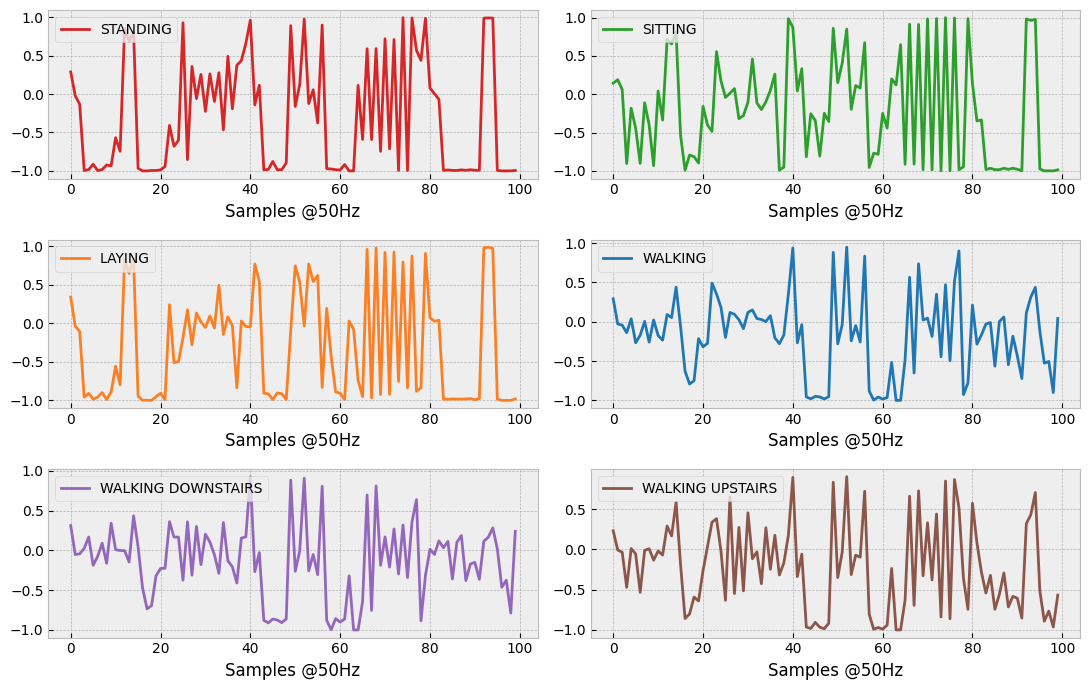

In [9]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,145,172]):
    plt.subplot(3,2,i+1)
    plt.plot(x_train[r][:100], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()

#### Model Performance
The performance of the KNN & DTW classifier is measured by comparing the class labels from the holdout dataset against predictions made by the classifier. The HAR dataset was pre-split into 70% training and 30% test. Cross validation was not performed.

In [10]:
m = KnnDtw(n_neighbors=1, max_warping_window=10)
m.fit(x_train[::100], y_train[::100])
label, proba = m.predict(x_test[::10])

                    precision    recall  f1-score   support

           WALKING       0.96      0.75      0.84        64
  WALKING UPSTAIRS       0.71      0.87      0.78        39
WALKING DOWNSTAIRS       0.75      0.85      0.80        39
           SITTING       0.57      0.55      0.56        53
          STANDING       0.62      0.48      0.54        65
            LAYING       0.65      0.97      0.78        35

          accuracy                           0.71       295
         macro avg       0.71      0.74      0.72       295
      weighted avg       0.72      0.71      0.70       295



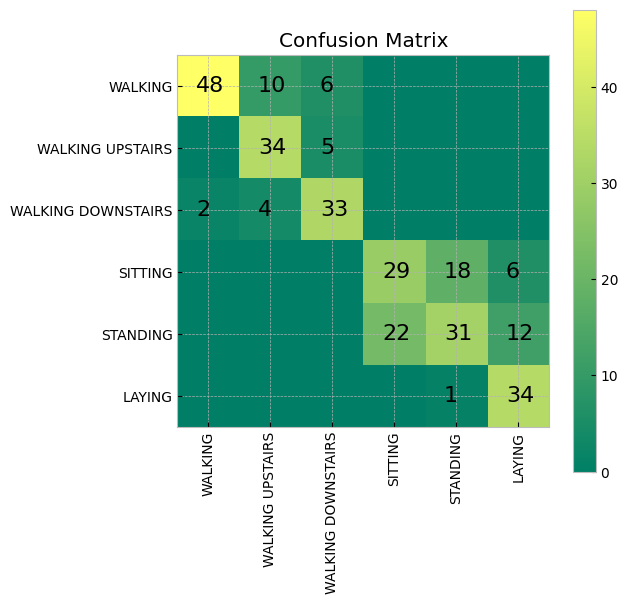

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label, y_test[::10],
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label, y_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

The KNN & DTW classifier performed very well across each of the 6 classes. It even beats the best classification rate published by the authors of the HAR paper.

However, this performance comes at a cost. The KNN algorithm is implemented using brute force. So, comparing 500 training observations to 500 test observations results in 250,000 DTW distances to be computed. And each (unconstrained) DTW distance calculation takes over 65K calculations each (256 x 256). This results in 16.3 billion calculations for just 500 x 500 observations.. Clearly not a scalable classification technique!

Performance improvements can be achieved by reducing the `max_warping_window` parameter. However, these gains will not be sufficient to make KNN & DTW a viable classification technique for large or medium sized datasets.

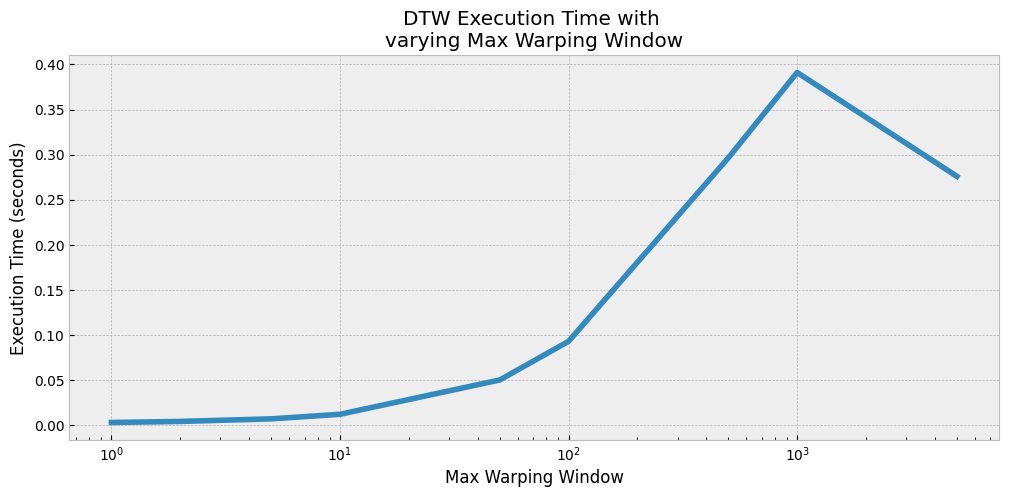

In [12]:
import time

time_taken = []
windows = [1,2,5,10,50,100,500,1000,5000]

for w in windows:
    begin = time.time()
    
    t = KnnDtw(n_neighbors=1, max_warping_window=w)
    t.fit(x_train[:20], y_train[:20])
    label, proba = t.predict(x_test[:20])
    
    end = time.time()
    time_taken.append(end - begin)

fig = plt.figure(figsize=(12,5))
_ = plt.plot(windows, [t/400. for t in time_taken], lw=4)
plt.title('DTW Execution Time with \nvarying Max Warping Window')
plt.ylabel('Execution Time (seconds)')
plt.xlabel('Max Warping Window')
plt.xscale('log')

---

#### Final thoughts
There are many improvements that could be made to this python implementation of KNN & DTW (eg. rewrite in C++ or explore parallel processing). However, the objective of this project was learning related. I've gained a deeper insight into the underlying mechanics of DTW by implementing it in python using dynamic programming techniques.

#### References
1.  Mitsa (2010). Temporal Data Mining (Chapter on Temporal Classification).
2.  Xi (2006). Fast Time Series Classification Using Numerosity Reduction.
3.  Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. Human Activity Recognition on Smartphones using a Multiclass Hardware-Friendly Support Vector Machine. International Workshop of Ambient Assisted Living (IWAAL 2012). Vitoria-Gasteiz, Spain. Dec 2012. [Read Paper](http://arxiv.org/pdf/1401.8212.pdf)

#### Credit
-  The progressbar used in the `DtwKnn()` class was taken from PYMC
-  The matplotlib style and IPython notebook was taken from Cameron Davidson-Pilon's excelent ["Bayesian Methods for Hackers"](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

# Вайбкодинг табличной задачи

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Возможные баги при установке
# https://github.com/timeseriesAI/tsai/issues/939
from tsai.data.external import get_UCR_univariate_list, get_UCR_data

# https://stackoverflow.com/questions/64541502/oserror-could-not-load-shared-object-file-llvmlite-dll-shap-related-what-cou
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
# Шаг 2. Загрузка примерного набора данных временных рядов
# Получим список доступных унивариатных (одномерных) датасетов UCR
dataset_list = get_UCR_univariate_list()
print("Доступно датасетов:", len(dataset_list))
print("Примеры первых 5 датасетов:", dataset_list[:5])

Доступно датасетов: 128
Примеры первых 5 датасетов: ['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ']


In [ ]:
# Выберем небольшой датасет из списка для демонстрации (например, OliveOil)
dataset_name = "Computers"  # название датасета
print(f"\nИспользуем датасет: {dataset_name}")

# Загрузим выборки: X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = get_UCR_data(dataset_name, split_data=True, on_disk=False)
print("Форма X_train:", X_train.shape)  # (количество серий, каналов, длина серии)
print("Форма X_test:", X_test.shape)
print("Количество классов в данных:", len(np.unique(y_train)), "; Метки классов:", np.unique(y_train))


Используем датасет: Computers
Форма X_train: (250, 1, 720)
Форма X_test: (250, 1, 720)
Количество классов в данных: 2 ; Метки классов: ['1' '2']


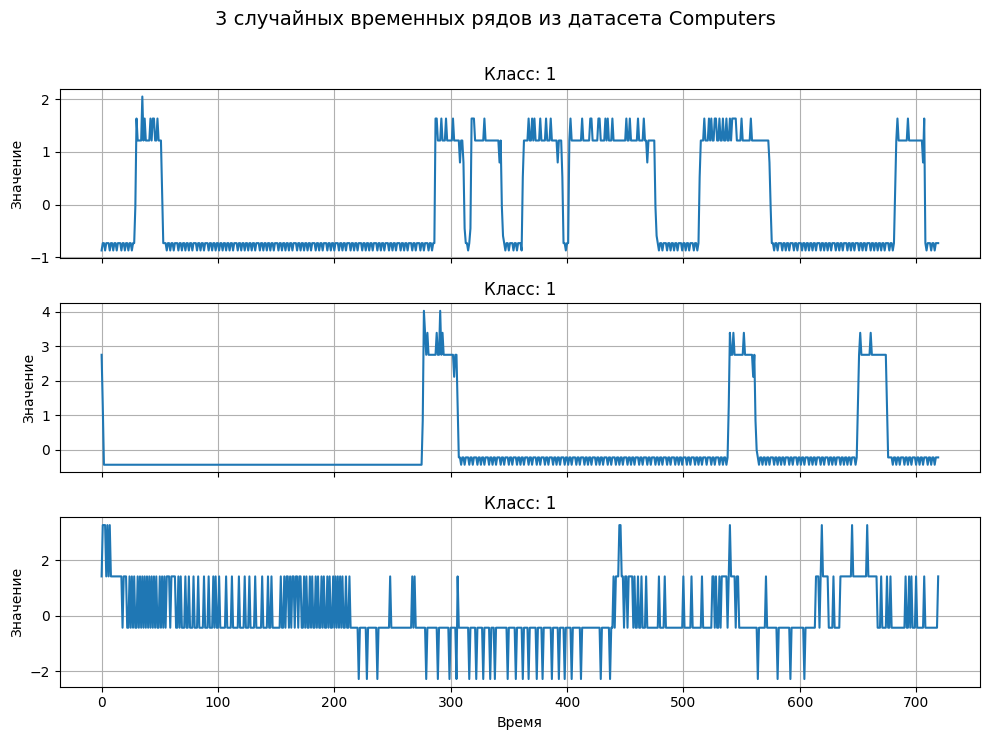

In [25]:
# Шаг 6. Визуализация нескольких примеров из обучающего набора

import random

# Задаём количество рядов для отображения
x = 3

# Получаем случайные индексы
random_indices = random.sample(range(len(X_train)), x)

# Создаём графики
fig, axs = plt.subplots(x, 1, figsize=(10, 2.5 * x), sharex=True)
fig.suptitle(f"{x} случайных временных рядов из датасета {dataset_name}", fontsize=14)

for i, idx in enumerate(random_indices):
    axs[i].plot(X_train[idx][0])  # только один канал (одномерный ряд)
    axs[i].set_title(f"Класс: {y_train[idx]}")
    axs[i].set_ylabel("Значение")
    axs[i].grid(True)

plt.xlabel("Время")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [26]:

# Шаг 3. Генерация признаков из временных рядов с помощью tsfresh
# Для использования tsfresh конвертируем наборы временных рядов в "длинный" формат DataFrame
rows = []
# Преобразуем обучающие серии: каждая точка во времени становится отдельной строкой в таблице
for i, series in enumerate(X_train):
    for t, value in enumerate(series[0]):  # series[0] потому что ряд одномерный (1 канал)
        rows.append([i, t, value])
# Преобразуем тестовые серии, продолжая нумерацию id
for j, series in enumerate(X_test):
    idx = len(X_train) + j  # уникальный id для каждой серии теста (после train)
    for t, value in enumerate(series[0]):
        rows.append([idx, t, value])
# Создаем DataFrame с колонками: id (номер серии), time (время/индекс), value (значение ряда)
df_ts = pd.DataFrame(rows, columns=['id', 'time', 'value'])
print(f"Длина таблицы с временными рядами для tsfresh: {len(df_ts)} строк")

# Используем tsfresh для извлечения признаков из каждого временного ряда
X_features = extract_features(df_ts, column_id='id', column_sort='time', column_value='value', impute_function=impute)
print("Матрица признаков получена. Размерность:", X_features.shape)
# X_features имеет размер [количество рядов x количество сгенерированных признаков]

Длина таблицы с временными рядами для tsfresh: 360000 строк


Feature Extraction: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Матрица признаков получена. Размерность: (500, 783)


In [27]:
# Разделяем матрицу признаков обратно на обучающую и тестовую части
N_train = len(y_train)
X_train_features = X_features.iloc[:N_train, :].copy()
X_test_features  = X_features.iloc[N_train:, :].copy()
# (Опционально, сбросим индексы для ясности)
X_train_features.index = range(N_train)
X_test_features.index = range(len(y_test))

Обучение завершено. Accuracy на обучающей выборке: 1.0
Accuracy на тестовой выборке: 0.78


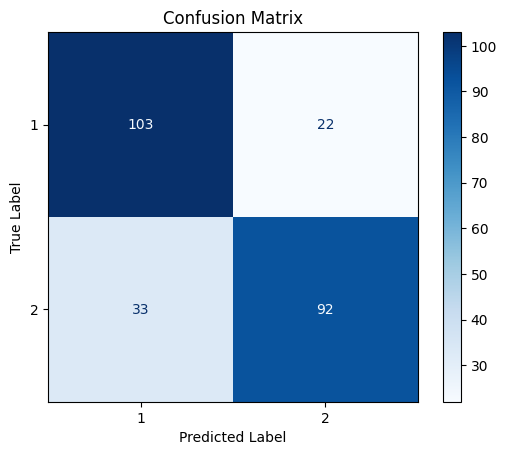

In [28]:


# Шаг 4. Обучение модели градиентного бустинга на полученных признаках
clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_features, y_train)
print("Обучение завершено. Accuracy на обучающей выборке:", clf.score(X_train_features, y_train))

# Шаг 5. Оценка модели на тестовых данных
y_pred = clf.predict(X_test_features)
acc_test = clf.score(X_test_features, y_test)
print(f"Accuracy на тестовой выборке: {acc_test:.2f}")

# Построение матрицы неточностей (confusion matrix) для визуализации результатов
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
